<a href="https://colab.research.google.com/github/pantelis/aiml-common/blob/master/lectures/regression/linear-regression/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Linear Regression

 Now that we have introduced somewhat more formally the learning problem and its notation lets us study a simple but instructive regression problem that is known in the statistics literature as *shrinkage*.

 Suppose that we are given the training set  $\mathcal D = \{(\mathbf x_i, y_i), i =1 \dots m\}$  where $\mathbf x_i \in \mathbb R^n$ the label $y_i \in \mathbb R$. We need to construct a model such that a *suitably chosen* loss function is minimized for a **different** set of input data, the so-called test set. The ability to correctly *predict* when observing the test set, is called **generalization**.

<img src="./images/Figure1.2.png" alt="dataset" class="bg-primary" width="300px">

*Training Dataset (m=10) for the Regression Model. The green curve is the uknown target function. Please replace the label axis denoted by $t$ with $y$ to make it compatible with our notation.*

 Since the output $y$ is a continuous variable then the supervised learning problem is called a regression problem (otherwise its a classification problem). The synthetic dataset is generated by the function $\sin(2 \pi x) + ϵ$ where $x$ is a uniformly distributed random variable and $ϵ$ is $N(\mu=0.0, \sigma^2=0.3)$. This target function is **completely unknown** to us - we just mention it here just to provide a visual clue of what the hypothesis set needs to aspire to.

In [1]:
!pip install git+https://github.com/pantelis-classes/PRML.git#egg=prml

import seaborn as sns

# Apply the default theme
sns.set_theme()


Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/pantelis-classes/PRML.git to /tmp/pip-install-4jmy2x2l/prml_d2cf171c4aa64b08b838dcd5fe8fe772
  Running command git clone --filter=blob:none --quiet https://github.com/pantelis-classes/PRML.git /tmp/pip-install-4jmy2x2l/prml_d2cf171c4aa64b08b838dcd5fe8fe772
  Resolved https://github.com/pantelis-classes/PRML.git to commit 14cf88538d2704fd18b391ae6309fb38c65a6412
  Preparing metadata (setup.py) ... done
  Created wheel for prml: filename=prml-0.0.1-py3-none-any.whl size=88407 sha256=8e8f307f19e75eaeee1f12cbbf40ff5ec4f201ab7a2a2c2d545f1fe4c241bff6
  Stored in directory: /tmp/pip-ephem-wheel-cache-g9hwg7ro/wheels/5d/56/f3/c40fd432ed3d5d565f131c2146282d43c65eb720576825e67f
Successfully built prml


In [2]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

from prml.preprocess import GaussianFeature, PolynomialFeature, SigmoidalFeature
from prml.linear import (
    BayesianRegression,
    EmpiricalBayesRegression,
    LinearRegression,
    RidgeRegression
)

np.random.seed(1234)


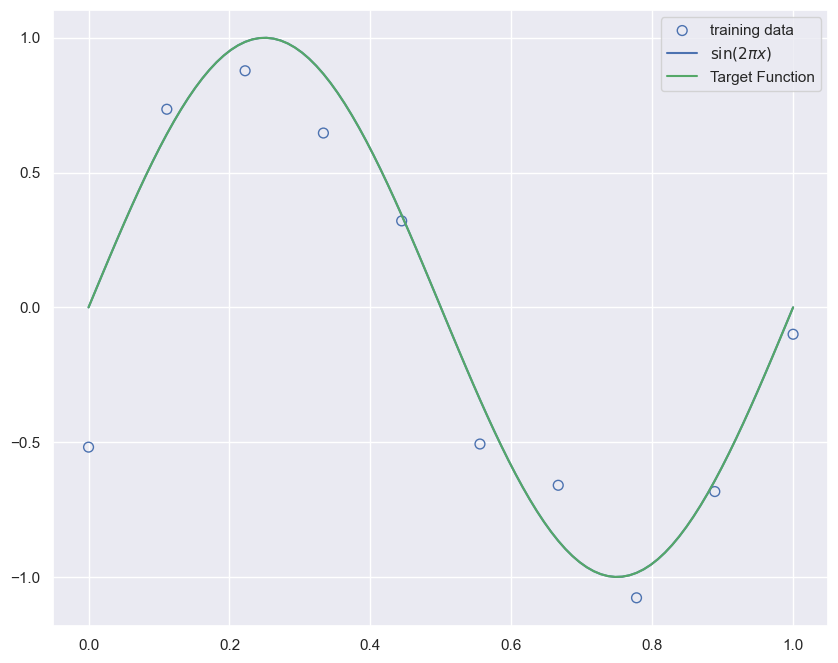

In [3]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y_test, "-g", label="Target Function")
plt.legend()
plt.show()


 Let us now pick the hypothesis set that corresponds in general to the following sum,

 $$g(\mathbf{w},\mathbf{x}) = w_0 + \sum_{j=1}^{M-1}w_j \phi_j(\mathbf x) = \mathbf w^T \mathbf \phi(\mathbf x)$$

 where $\phi_j(\mathbf x)$ are know as _basis functions_. A set of Polynomial, Gaussian and Sigmoidal basis functions are plotted below.

Text(0.5, 0.01, 'Polynomial, Gaussian and Sigmoidal basis functions')

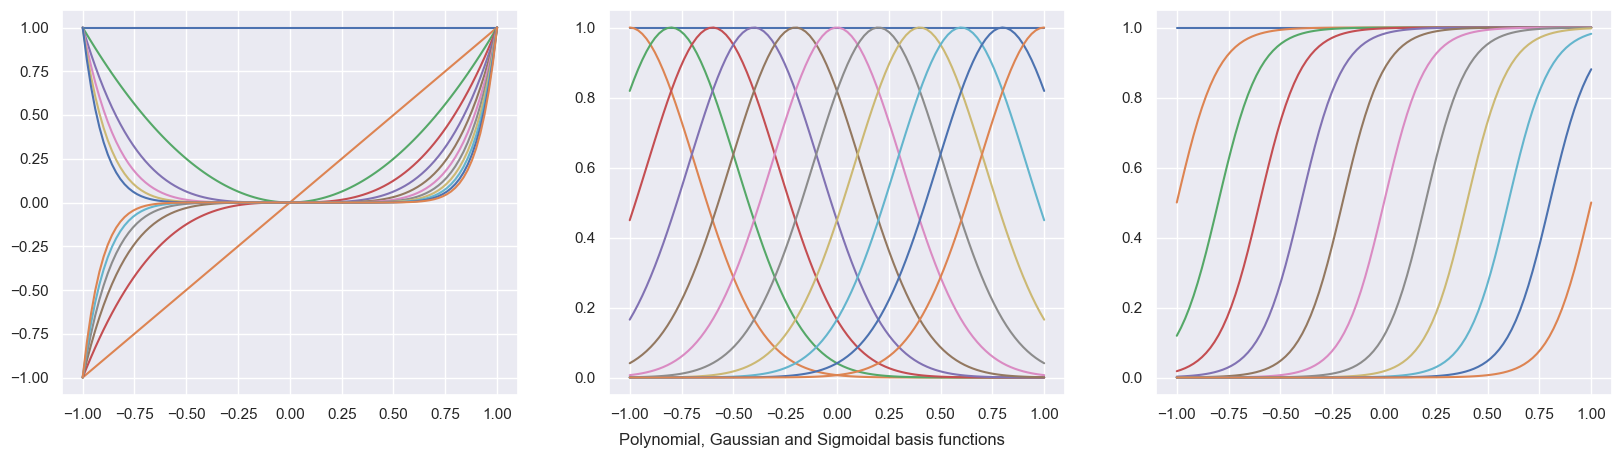

In [4]:
x = np.linspace(-1, 1, 100)
X_polynomial = PolynomialFeature(11).transform(x[:, None])
X_gaussian = GaussianFeature(np.linspace(-1, 1, 11), 0.1).transform(x)
X_sigmoidal = SigmoidalFeature(np.linspace(-1, 1, 11), 10).transform(x)

plt.figure(figsize=(20, 5))
for i, X in enumerate([X_polynomial, X_gaussian, X_sigmoidal]):
    plt.subplot(1, 3, i + 1)
    for j in range(12):
        plt.plot(x, X[:, j])
txt="Polynomial, Gaussian and Sigmoidal basis functions"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)


 Our job is to find $\mathbf{w}$ such that the polynomial expansion above fits the data we are given - as we will see there are multiple hypothesis that can satisfy this requirement. Consistent with the block diagram we need to define a metric, an figure of merit or loss function in fact, that is also a common metric in regression problems of this nature. This is the Mean Squared Error (MSE) function.

 $$L(\mathbf{w}) = \frac{1}{m} \sum_{i=1}^m \{(g(\mathbf{w},x_i)-y_i)\}^2$$
 .
 ![Loss Function](images/Figure1.3.png)

 *The loss function chosen for this regression problem, corresponds to the sum of the squares of the displacements of each data point and our hypothesis. The sum of squares in the case of Gaussian errors gives raise to an (unbiased) Maximum Likelihood estimate of the model parameters. Contrast this to sum of absolute differences.*

 Now our job has become to choose two things: the weight vector $\mathbf{w^*}$ *and* $M$ the order of the polynomial. **Both** define our hypothesis.  If you think about it, the order $M$ defines the model complexity in the sense that the larger $M$ becomes the more the number of weights we need to estimate and store. Obviously this is a trivial example and storage is not a concern here but treat this example as instructive for that it applies in far for complicated settings.

 <!-- :::{figure-md} markdown-fig -->
 <img src="./images/Figure1.4a.png" alt="M=0" class="bg-primary mb-1" width="300px">
 <img src="./images/Figure1.4b.png" alt="M=1" class="bg-primary mb-1" width="300px">
 <img src="./images/Figure1.4c.png" alt="M=3" class="bg-primary mb-1" width="300px">
 <img src="./images/Figure1.4d.png" alt="M=9" class="bg-primary mb-1" width="300px">

 _Various final hypotheses._
 <!-- ::: -->


 Obviously you can reduce the training error to almost zero by selecting a model that is complicated enough (M=9) to perfectly fit the training data (if m is small).

 ![Loss Function](images/Figure1.5.png)

 But this is not what you want to do. Because when met with test data, the model will perform far worse than a less complicated model that is closer to the true model (e.g. M=3). This is a central observation in statistical learning called **overfitting**. In addition, you may not have the time to iterate over M (very important in online learning settings).

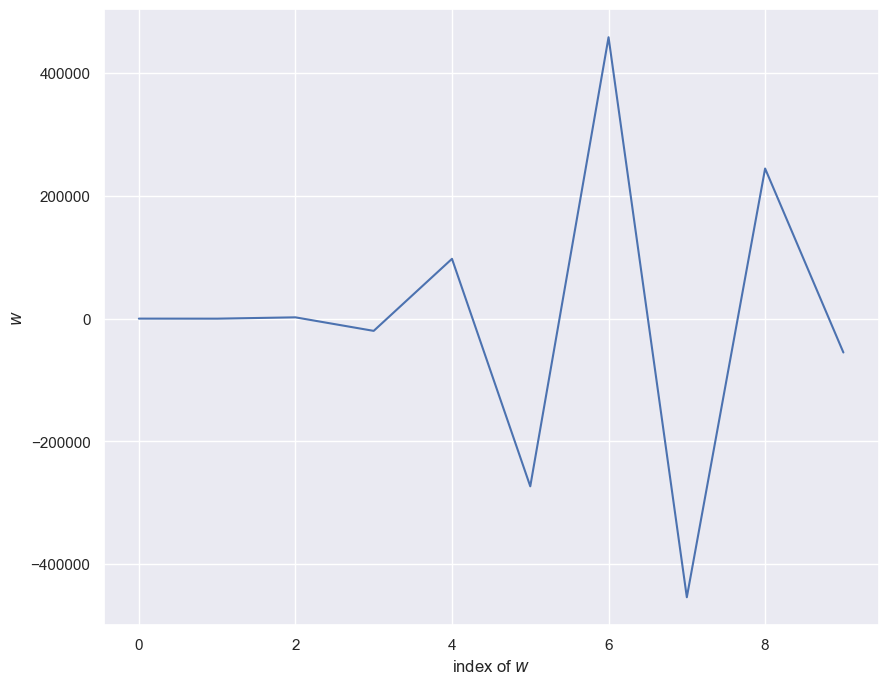

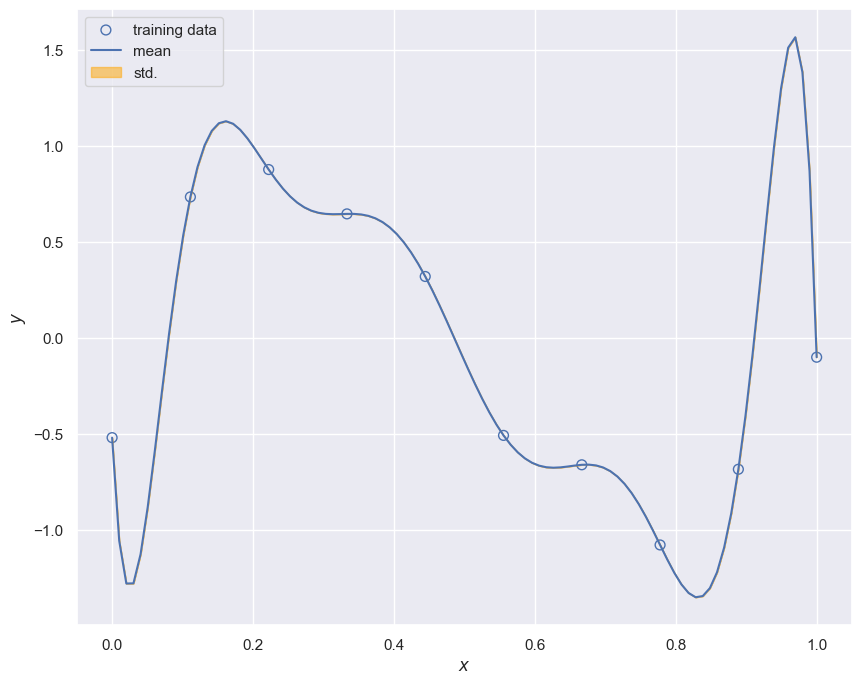

In [5]:
M=9
# Pick one of the three features below
feature = PolynomialFeature(M)
#feature = GaussianFeature(np.linspace(0, 1, M), 0.1)
# feature = SigmoidalFeature(np.linspace(0, 1, M), 10)

X_train = feature.transform(x_train)
X_test = feature.transform(x_test)
model = LinearRegression()
model.fit(X_train, y_train)

plt.figure(figsize=[10,8])
plt.plot(model.w) 
plt.xlabel("index of $w$")
plt.ylabel("$w$")

y, y_std = model.predict(X_test, return_std=True)

plt.figure(figsize=[10,8])

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y, label="mean")
plt.fill_between(
    x_test, y - y_std, y + y_std,
    color="orange", alpha=0.5, label="std.")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")

plt.show()


 To avoid overfitting we have multiple strategies. One straightforward one is evident by observing the wild oscillations of the $\mathbf{w}$ elements as the model complexity increases. We can penalize such oscillations by introducing the $l_2$ norm of $\mathbf{w}$ in our loss function.

 $$L(\mathbf{w}) = \frac{1}{2} \sum_{i=1}^m \{(g(\mathbf{w},x_i)-y_i)\}^2 + \frac{\lambda}{2} ||\mathbf{w}||^2$$

 This type of solution is called **regularization** and because we effectively shrink the weight dynamic range it is also called in statistics shrinkage or ridge regression. We have introduced a new parameter $\lambda$ that regulates the relative importance of the penalty term as compared to the MSE. This parameter together with the polynomial order is what we call *hyperparameters* and we need to optimize them as both are needed for the determination of our final hypothesis $g$.

 The graph below show the results of each search iteration on the $\lambda$ hyperparameter.

 ![Loss Function](images/Figure1.8.png)

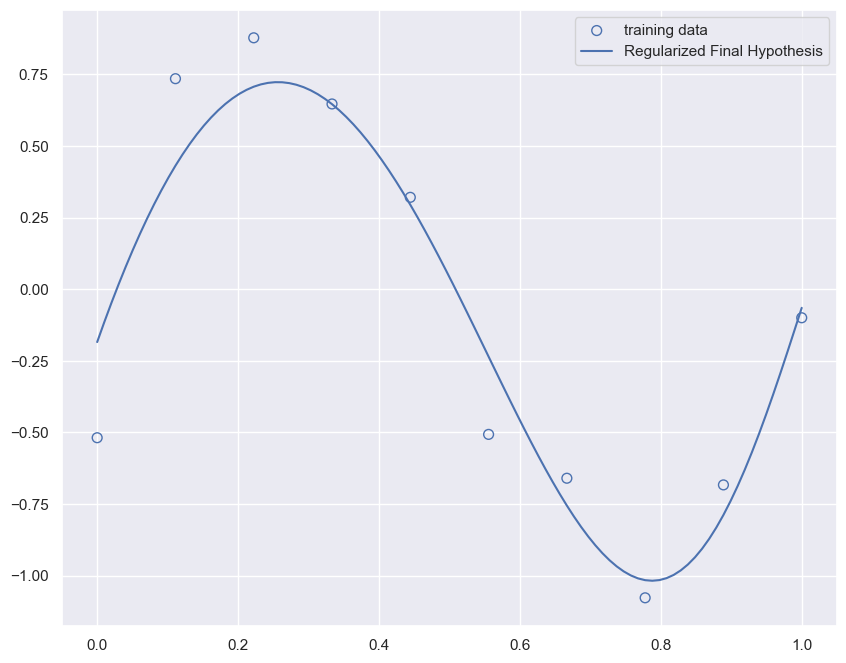

In [6]:
model = RidgeRegression(alpha=1e-3)
model.fit(X_train, y_train)
y = model.predict(X_test)

plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y, label="Regularized Final Hypothesis")
plt.legend()
plt.show()


 Lets reflect on the MSE and how model complexity gives raise to various generalization errors.

 $$MSE = \mathbb{E}[(\hat{y}_i - y_i)^2] = \mathrm{Bias}(\hat{y}_i)^2 + \mathrm{Var}(\hat{y}_i)$$

 which means that the [MSE captures both bias and variance](https://en.wikipedia.org/wiki/Mean_squared_error) of the estimated target variables and as shown in the plots above, increasing model capacity can really increase the variance of $\hat{y}$. We have seen that as the $\mathbf{w}$ is trying to exactly fit, or memorize, the data, it minimizes the bias (in fact for model complexity M=9 the bias is 0) but it also exhibits significant variability that is itself translated to $\hat{y}$. Although the definition of model *capacity* is far more rigorous, we will broadly associate complexity with capacity and borrow the figure below from Ian Goodfellow's book to demosntrate the tradeoff between bias and variance. What we have done with regularization is to find the $\lambda$ that minimized generalization error aka. find the optimal model capacity.

 ![generalization-error-vs-capacity](images/generalization-capacity.png)

 *As capacity increases (x-axis), bias (dotted) tends to decrease and variance(dashed) tends to increase, yielding another U-shaped curve for generalization error (bold curve). If we vary capacity along one axis, there is an optimal capacity, with underﬁtting when the capacity is below this optimum and overﬁtting when it is above.*

 ## Bias and Variance Decomposition during the training process

 Apart from the composition of the generalization error for various model capacities,  it is interesting to make some general comments regarding the decomposition of the generalization error (also known as empirical risk) during training. Early in training the bias is large because the predictor output is far from the target function. The variance is very small because the data has had little influence yet. Late in training the bias is small because the predictor has learned the underlying function. However if train for too long then the predictor will also have learned the noise specific to the dataset (overfitting). In such case the variance will be large because the noise varies between training and test datasets.

 ## References

 This notebook makes extensive use of the [Pattern Recognition for Machine Learning python package](https://github.com/ctgk/PRML).